In [1]:
import tensorflow as tf
tf.enable_eager_execution()
tfe = tf.contrib.eager

from os import listdir
import matplotlib.pyplot as plt
from matplotlib import pyplot
import numpy as np
import time
from PIL import Image
import numpy as np
import cv2
from IPython import display
from tensorflow.python.keras import models
from tensorflow.keras.layers import Conv2D, UpSampling2D, RepeatVector,concatenate,BatchNormalization

from utils import *

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Step 1: Read Data

In [38]:
# ! unzip train_8k.zip

In [39]:
# # Read images from folder
# height = 224
# width  = 224

# from os import listdir

# def loadImages(path):
#   """This function will load images from folder
  
#   Arguments:
#     path: the folder path
      
#   Returns:
#     returns a list contains all images
#   """
#   imagesList = listdir(path)
#   loadedImages = []
#   for image in imagesList:
#     if image[::-1][:4] == '.jpg'[::-1]:
#       img = Image.open(path + image)
#       img = img.resize((width, height))
#       loadedImages.append(img)
#   return loadedImages

# path = "./train/"
# source_images = loadImages(path)
# n=len(source_images)

In [40]:
# source_array = []
# for i in range(n):
#   temp = np.asarray(source_images[i], dtype='float32')/255.
#   if temp.shape[-1] == 3:
#       source_array.append(cv2.cvtColor(temp, cv2.COLOR_RGB2LAB))
# source_array = np.asarray(source_array,dtype='float32')
# print(source_array.shape)

In [41]:
# source_array = source_array[:50,:,:,:]

In [42]:
# # Get the input for vgg16
# means = np.mean(source_array, tuple(range(3)),dtype='float32'); print('means: ', means)
# source_array -= means

In [43]:
# source_l = np.asarray([source[:,:,0] for source in source_array])
# source_l -= 50
# source_ab = np.asarray([source[:,:,1:] for source in source_array])
# # source_ab = source_ab/128*100

In [3]:
means = 50
# means = 5.390305

In [4]:
# Version 2: read data from path_lst 
def loadImages(paths, width,height):
    loadedImages = []
    for p in paths:
        image = p.numpy().decode("utf-8") 
        if image[::-1][:4] == '.jpg'[::-1]:
            img = Image.open(image)
            img = img.resize((width, height))
            loadedImages.append(img)
    return loadedImages

In [5]:
def get_batch_img(paths,means,width,height):
  imgs = loadImages(paths,width,height)
  n = len(imgs)
  imgs_array = []
  for i in range(n):
    temp = np.asarray(imgs[i], dtype='float32')/255.
    if len(temp.shape) == 3:
      imgs_array.append(cv2.cvtColor(temp, cv2.COLOR_RGB2LAB))
  imgs_array = np.asarray(imgs_array,dtype='float32')
  imgs_l = np.asarray([img[:,:,0] for img in imgs_array])
  imgs_l -= means
  imgs_ab = np.asarray([img[:,:,1:] for img in imgs_array])
  return imgs_l,imgs_ab

## Step 2: Extract Features

In [6]:
# def encoder_and_fusion(source_l,high_layers,mid_layers):
#   vgg16 = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=True, weights=None)
#   vgg16.load_weights('mobilenet_1_0_224_tf.h5')
#   vgg16.trainable = False
#   for layer in vgg16.layers:
#     if layer.name in ['conv_pw_13','conv_pw_13_bn','conv_preds']:
#         layer.trainable = True
#     else:
#         layer.trainable = False
#   high_features = [vgg16.get_layer(l).output for l in high_layers] 
#   mid_features = [vgg16.get_layer(l).output for l in mid_layers]    
#   outputs = high_features + mid_features
#   model = models.Model(vgg16.input,outputs)
#   source_l = np.repeat(source_l,3).reshape(source_l.shape[0],source_l.shape[1],
#                                            source_l.shape[2],3)
#   x = model(source_l)
#   x_high = x[0]
#   x_mid = x[1]
#   x = np.repeat(x_high,x[1].shape[1]*x[1].shape[2]).reshape([x_high.shape[0],
#                                                                x_mid.shape[1],x_mid.shape[1],x_high.shape[1]])
#   x = concatenate([x,x_mid],axis=3)
#   return x

In [6]:
# Version 2: fine-tuning
class encoder_and_fusion(tf.keras.Model):
  def __init__(self):
    super(encoder_and_fusion, self).__init__()
    self.vgg16 = tf.keras.applications.mobilenet.MobileNet(input_shape=(224, 224, 3), include_top=True)
  
  def call(self, x, training=True):
    self.vgg16.trainable=False
    for layer in self.vgg16.layers:
        if layer.name in ['conv_pw_13','conv_pw_13_bn','conv_preds']:
            layer.trainable = True
        else:
            layer.trainable = False
    high_features = [self.vgg16.get_layer(l).output for l in high_layers] 
    mid_features = [self.vgg16.get_layer(l).output for l in mid_layers]   
    outputs = high_features + mid_features
    model = models.Model(self.vgg16.input,outputs)
    x = np.repeat(x,3).reshape(x.shape[0],x.shape[1],x.shape[2],3)
    x = model(x)
    x_high = x[0]
    x_mid = x[1]
    x = np.repeat(x_high,x[1].shape[1]*x[1].shape[2]).reshape([x_high.shape[0],
                                                               x_mid.shape[1],x_mid.shape[1],x_high.shape[1]])
    x = concatenate([x,x_mid],axis=3)
    return x

In [7]:
encoder = encoder_and_fusion()

In [8]:
# Version 2: make path_lst to be a tf.dataset
def get_batch_tf_dataset(folder_path,batch_size):
  paths = [folder_path + i for i in listdir(folder_path)]
  buffer_size = len(paths)
  dataset = tf.data.Dataset.from_tensor_slices(paths).shuffle(buffer_size).batch(batch_size).prefetch(1)
  return dataset

In [9]:
folder_path = './train/'
batch_size = 60

In [10]:
dataset = get_batch_tf_dataset(folder_path,batch_size)

In [11]:
# mid_layers = ['conv_dw_5_bn']
# high_layers = ['reshape_2']

In [12]:
# source_features = encoder_and_fusion(source_l,high_layers,mid_layers)

In [12]:
class Decoder_Model(tf.keras.Model):
  def __init__(self):
    super(Decoder_Model, self).__init__()
    self.decoder_conv1 = Conv2D(filters=512, kernel_size=(1,1), strides=1, padding="same", activation='relu')
    self.decoder_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_upsamp1 = UpSampling2D((2,2))
    self.decoder_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_conv4 = Conv2D(filters=256, kernel_size=(3,3), strides=1, padding="same", activation='relu')
    self.decoder_conv5 = Conv2D(filters=313, kernel_size=(1,1), strides=1, padding="same") #dense layer
    
  
  def call(self, x):
    x = self.decoder_conv1(x)
    x = self.decoder_conv2(x)
    x = self.decoder_upsamp1(x)
    x = self.decoder_conv3(x)
    x = self.decoder_conv4(x)
    x = self.decoder_conv5(x)
    
    return x

In [13]:
decoder = Decoder_Model()

In [15]:
# read data
height = 224
width = 224
test_image = Image.open('goat.jpg')
test_image = test_image.resize((width, height))

# data preprocess
test_array = np.asarray(test_image, dtype='float32')/255.
test_array = cv2.cvtColor(test_array,cv2.COLOR_RGB2LAB)
test_array = np.expand_dims(test_array,axis=0)

# extract featuresa
test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
test_l -= 50
encoder(test_l)
encoder.load_weights('encoder_epoch150.h5')
test_features = encoder(test_l)

# predict images
decoder(test_features)
decoder.load_weights('decoder_epoch150.h5')

In [15]:
# conv8_313 = decoder(source_features)

## Step 3: Prepare for Prediction

In [16]:
def get_ab_class(data_ab):
  
  NN = 30
  sigma = 5

  data_ab = np.transpose(data_ab, (0, 3, 1, 2))
  nnenc = NNEncode(NN, sigma, km_filepath='pts_in_hull.npy')
  gt_ab_313 = nnenc.encode_points_mtx_nd(data_ab, axis=1)

  gt_ab_313 = np.transpose(gt_ab_313, (0, 2, 3, 1))
  return gt_ab_313

In [17]:
# gt_ab_313 = tf.cast(tf.convert_to_tensor(get_ab_class(source_ab[:, ::4, ::4, :])),tf.float32)

In [18]:
def get_ab_distribution(data_ab,gt_ab_313):
  thresh = 5
  nongray_mask = (np.sum(np.sum(np.sum(np.abs(data_ab) > thresh, axis=1), axis=1), axis=1) > 0)[:, np.newaxis, np.newaxis, np.newaxis]
  
  #Prior_Boost 
  #prior_boost: [N, 1, H/4, W/4]
  prior_boost = get_prior_boost(gt_ab_313)

  #Eltwise
  #prior_boost_nongray: [N, 1, H/4, W/4]
  prior_boost_nongray = prior_boost * nongray_mask

  return prior_boost_nongray

In [83]:
# prior_boost_nongray = get_ab_distribution(source_ab,gt_ab_313)

In [84]:
# # Version 1: w/o prior_boost_nongray
# def compute_loss(decoder_out, prior_boost_nongray, gt_ab_313):
#     #decoder_out = tfe.Variable(decoder_out,tf.float32)
#     flat_conv8_313 = tf.reshape(decoder_out, [-1, 313])
#     flat_gt_ab_313 = tf.reshape(gt_ab_313,[-1,313])
#     g_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = flat_conv8_313, labels = flat_gt_ab_313)) 
#   return g_loss

In [19]:
# Version 1: w/o prior_boost_nongray
def compute_loss(decoder_out, prior_boost_nongray, gt_ab_313):
    #decoder_out = tfe.Variable(decoder_out,tf.float32)
    flat_conv8_313 = tf.reshape(decoder_out, [-1, 313])
    flat_gt_ab_313 = tf.reshape(gt_ab_313,[-1,313])
    g_loss = tf.reduce_sum(tf.nn.softmax_cross_entropy_with_logits(logits = flat_conv8_313, labels = flat_gt_ab_313)) 
    prior_weight = tf.reshape(prior_boost_nongray,[-1])
    prior_weight = tf.cast(prior_weight,tf.float32)
    new_loss = tf.reduce_mean(tf.multiply(g_loss,prior_weight))
    return new_loss

In [86]:
# buffer_size = len(source_array)
# batch_size = 5

# dataset = tf.data.Dataset.from_tensor_slices((source_features,prior_boost_nongray,gt_ab_313)).shuffle(buffer_size).batch(batch_size).prefetch(1)

## Step 4: Train

In [20]:
opt = tf.train.AdamOptimizer(learning_rate=1e-3)
# first 100 1e-3, after 60 5e-4, after 160 1e-4(20)
# opt = tf.contrib.opt.AdamWOptimizer(weight_decay=1,learning_rate=1e-2,
#                                     beta1=0.9,beta2=0.999)

In [88]:
# def train_step(model,source_features,prior_boost_nongray,gt_ab_313):
  
#   with tf.GradientTape() as tape:
#     conv8_313_value = model(source_features)
#     loss = compute_loss(conv8_313_value,prior_boost_nongray,gt_ab_313)

#   grads = tape.gradient(loss,model.variables)
#   opt.apply_gradients(zip(grads, model.variables))
#   return loss

In [89]:
# Version 2: fine tuning
def train_step(model1,model2,source_l,high_layers,mid_layers,prior_boost_nongray,gt_ab_313):
  
  with tf.GradientTape() as tape1, tf.GradientTape() as tape2:
    source_features = model1(source_l)
    conv8_313_value = model2(source_features)
    loss = compute_loss(conv8_313_value,prior_boost_nongray,gt_ab_313)

  grads = tape2.gradient(loss,model2.variables)
  opt.apply_gradients(zip(grads, model2.variables))
  fine_grads = tape1.gradient(loss,model1.variables)
  opt.apply_gradients(zip(fine_grads, model1.variables))
  return loss

In [90]:
# # Compile the training step with defun for increased performance(graph mode)
# train_step = tf.contrib.eager.defun(train_step)

## Step 5: Display and Show

In [191]:
epochs = 30

In [92]:
# def train_and_display():
#   display.clear_output(wait=True)
#   conv8_313 = decoder(source_features)
#   imgs = decode(source_l,conv8_313, rebalance=0.38)
  
#   #fig = plt.figure(figsize=(10,10))
#   fig =plt.figure(figsize=(20,10))
#   for i in range(len(imgs)):  
#     plt.subplot(5,(len(imgs)//5)+1, i+1)
#     plt.imshow(imgs[i])
#     plt.axis('off')
#   plt.show()  

In [93]:
# Version 2: solve OOM problem
def train_and_display(model, source_l, source_features):
  display.clear_output(wait=True)
  conv8_313 = model(source_features)
  imgs = decode(tf.cast(source_l,tf.float32),conv8_313, rebalance)
  
  #fig = plt.figure(figsize=(10,10))
  fig =plt.figure(figsize=(20,10))
  for i in range(len(imgs)):  
    plt.subplot(5,(len(imgs)//5)+1, i+1)
    plt.imshow(imgs[i])
    plt.axis('off')
  plt.show()

In [94]:
# for epoch in range(epochs):
#   start = time.time()
#   loss = 0
#   for idx,data in enumerate(dataset):
#     #loss = train_step(decoder,np.expand_dims(source_features[i,:,:,:],axis=0),
#     #                        np.expand_dims(source_ab[i,:,:,:],axis=0))
    
#     loss += train_step(decoder,data[0],data[1],data[2])
#   end = time.time()
  
#   train_and_display()
#   print ('Epoch {}. Seconds {}'.format(epoch, end - start))
#   print ('Epoch {}. Total Loss {}'.format(epoch,loss))
#   #print ('Epoch {}. Gradients {}'.format(epoch,grads))

In [95]:
# # Version 2: add more train dataset.
# rebalance = 0.38
# high_layers = ['reshape_2']
# mid_layers = ['conv_dw_5_bn']
# width = 224
# height = 224

# for epoch in range(epochs):
#     start = time.time()
#     loss = 0
#     for idx, batch_path in enumerate(dataset):
#         batch_l, batch_ab = get_batch_img(batch_path,means,width,height)
#         batch_features = encoder_and_fusion(batch_l,high_layers,mid_layers)
#         batch_gt_ab_313 = tf.cast(tf.convert_to_tensor(get_ab_class(batch_ab[:, ::4, ::4, :])),tf.float32)
#         batch_prior_boost_nongray = get_ab_distribution(batch_ab,batch_gt_ab_313)
#         loss += train_step(decoder,batch_features,batch_prior_boost_nongray,batch_gt_ab_313)
#         #train_and_display(decoder, batch_l,batch_features)
#     end = time.time()
    
#     print ('Epoch {}. Seconds {}'.format(epoch, end - start))
#     print ('Epoch {}. Total Loss {}'.format(epoch,loss))
#     #print ('Epoch {}. Gradients {}'.format(epoch,grads))

In [192]:
# Version 3: fine tuning
rebalance = 0.38
high_layers = ['reshape_2']
mid_layers = ['conv_dw_5_bn']
width = 224
height = 224

for epoch in range(epochs):
    start = time.time()
    loss = 0
    for idx, batch_path in enumerate(dataset):
        batch_l, batch_ab = get_batch_img(batch_path,means,width,height)
        batch_gt_ab_313 = tf.cast(tf.convert_to_tensor(get_ab_class(batch_ab[:, ::4, ::4, :])),tf.float32)
        batch_prior_boost_nongray = get_ab_distribution(batch_ab,batch_gt_ab_313)
        loss += train_step(encoder,decoder,batch_l,high_layers,mid_layers,batch_prior_boost_nongray,batch_gt_ab_313)
        #train_and_display(decoder, batch_l,batch_features)
    end = time.time()
    
    print ('Epoch {}. Seconds {}'.format(epoch, end - start))
    print ('Epoch {}. Total Loss {}'.format(epoch,loss))
    #print ('Epoch {}. Gradients {}'.format(epoch,grads))

Epoch 0. Seconds 736.3271627426147
Epoch 0. Total Loss 346817824.0
Epoch 1. Seconds 737.835791349411
Epoch 1. Total Loss 347106048.0
Epoch 2. Seconds 737.530207157135
Epoch 2. Total Loss 347713600.0
Epoch 3. Seconds 737.454087972641
Epoch 3. Total Loss 346321088.0
Epoch 4. Seconds 738.8668487071991
Epoch 4. Total Loss 346454080.0
Epoch 5. Seconds 737.5251548290253
Epoch 5. Total Loss 346383552.0
Epoch 6. Seconds 738.4084038734436
Epoch 6. Total Loss 346387584.0
Epoch 7. Seconds 738.9014112949371
Epoch 7. Total Loss 345837248.0
Epoch 8. Seconds 738.5533540248871
Epoch 8. Total Loss 345417984.0
Epoch 9. Seconds 740.521922826767
Epoch 9. Total Loss 344814720.0
Epoch 10. Seconds 739.1615965366364
Epoch 10. Total Loss 344668480.0
Epoch 11. Seconds 739.8851664066315
Epoch 11. Total Loss 344455680.0
Epoch 12. Seconds 740.156715631485
Epoch 12. Total Loss 344717280.0
Epoch 13. Seconds 740.1294128894806
Epoch 13. Total Loss 345188672.0
Epoch 14. Seconds 772.9152565002441
Epoch 14. Total Loss 34

In [193]:
encoder.save_weights('encoder_epoch150.h5')

In [194]:
decoder.save_weights('decoder_epoch150.h5')

In [227]:
rebalance = 0.7

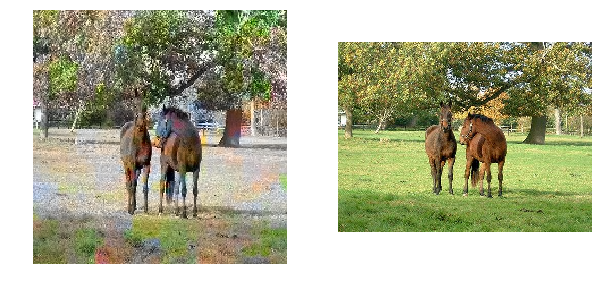

In [228]:
# read data
height = 224
width = 224
test_image = Image.open('house.jpg')
test_image = test_image.resize((width, height))

# data preprocess
test_array = np.asarray(test_image, dtype='float32')/255.
test_array = cv2.cvtColor(test_array, cv2.COLOR_RGB2LAB)
test_array = np.expand_dims(test_array,axis=0)

# extract features
test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
test_l -= 50
test_features = encoder(test_l)

# predict images
test_conv8_313 = decoder(test_features)
test_img_pred = decode(tf.cast(test_l,tf.float32),test_conv8_313, rebalance)
test_img_pred = np.asarray(test_img_pred)

# show the result
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(test_img_pred[0,:,:,:])
plt.grid(False)
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(cv2.cvtColor(cv2.imread('house.jpg',-1), cv2.COLOR_BGR2RGB))
plt.grid(False)
plt.axis('off')
plt.show()

## Step 6: Write Out Tests

In [38]:
# !unzip test.zip 

Archive:  test.zip
   creating: test/test/
  inflating: test/test/__29cDw6oC0.jpg  
  inflating: test/test/_1Z4zsEXUSk.jpg  
  inflating: test/test/_8B4U1lp4tg.jpg  
  inflating: test/test/_bzeQ0xgZcE.jpg  
  inflating: test/test/_DMC_h7LKp0.jpg  
  inflating: test/test/_FOPZiYQ268.jpg  
  inflating: test/test/_GQCzeh1oWk.jpg  
  inflating: test/test/_irVG9vKEss.jpg  
  inflating: test/test/_JddYBwbN9A.jpg  
  inflating: test/test/_ks5iOkzCII.jpg  
  inflating: test/test/_q4fv1WPx6o.jpg  
  inflating: test/test/_qUENfRc1wY.jpg  
  inflating: test/test/_RKgPSdFEz0.jpg  
  inflating: test/test/_rLDh9IFHf8.jpg  
  inflating: test/test/_SMNO4cN9vs.jpg  
  inflating: test/test/_VTnBdYFXXk.jpg  
  inflating: test/test/0_vRmdJe3Qo.jpg  
  inflating: test/test/000000002505.jpg  
  inflating: test/test/000000008239.jpg  
  inflating: test/test/000000008825.jpg  
  inflating: test/test/000000009228.jpg  
  inflating: test/test/000000011063.jpg  
  inflating: test/test/000000017053.jpg  
  inflat

  inflating: test/test/01wcdBbS2_0.jpg  
  inflating: test/test/026b234177cbe6fe.jpg.jpg  
  inflating: test/test/03b21fb42485372c.jpg.jpg  
  inflating: test/test/041a28a56ec73f41.jpg.jpg  
  inflating: test/test/06f9345aa4e501f8.jpg.jpg  
  inflating: test/test/072f0c6ea2ca3db4.jpg.jpg  
  inflating: test/test/079f1facd6223f0c.jpg.jpg  
  inflating: test/test/07c302b371a347f0.jpg.jpg  
  inflating: test/test/08a94bf9d487fc58.jpg.jpg  
  inflating: test/test/093ab55e46fe2e60.jpg.jpg  
  inflating: test/test/0a70f739f5470c48.jpg.jpg  
  inflating: test/test/0AfBGTPHnnQ.jpg  
  inflating: test/test/0b19b57b99ea7d55.jpg.jpg  
  inflating: test/test/0b547b133e10a0d8.jpg.jpg  
  inflating: test/test/0BQF3phvLC8.jpg  
  inflating: test/test/0cdf74810d6c9e2f.jpg.jpg  
  inflating: test/test/0ee6c01f76db86fb.jpg.jpg  
  inflating: test/test/0ef7a8c6ac8963c1.jpg.jpg  
  inflating: test/test/0febb6fee08a7470.jpg.jpg  
  inflating: test/test/0G4QNbmlYdw.jpg  
  inflating: test/test/0HvnSVQy1dk.j

  inflating: test/test/2012_003650.jpg  
  inflating: test/test/2012_003684.jpg  
  inflating: test/test/2012_003889.jpg  
  inflating: test/test/2012_003932.jpg  
  inflating: test/test/20X17NOWhcA.jpg  
  inflating: test/test/22160e69a2a1f717.jpg.jpg  
  inflating: test/test/25gAg2MOXxQ.jpg  
  inflating: test/test/26b45e4572605eb1.jpg.jpg  
  inflating: test/test/27xBJmvhXtg.jpg  
  inflating: test/test/280876b5da4c2421.jpg.jpg  
  inflating: test/test/2951ce40f585fe88.jpg.jpg  
  inflating: test/test/2a2f9b3ce21c8923.jpg.jpg  
  inflating: test/test/2a4a807a9877f9cb.jpg.jpg  
  inflating: test/test/2aPfcyAC2cc.jpg  
  inflating: test/test/2c5484849d627779.jpg.jpg  
  inflating: test/test/2c893e2ca564ad6d.jpg.jpg  
  inflating: test/test/2daddfbc60c8747c.jpg.jpg  
  inflating: test/test/2dvJDei7_6k.jpg  
  inflating: test/test/2DXqsO2eY3I.jpg  
  inflating: test/test/2f6bc7764eafa8ef.jpg.jpg  
  inflating: test/test/2fb4c3107a73173d.jpg.jpg  
  inflating: test/test/2fbded9ce32e8dc6.

  inflating: test/test/8CNPkipuHLM.jpg  
  inflating: test/test/8DUn1ltm8Z0.jpg  
  inflating: test/test/8eOKsatMrnM.jpg  
  inflating: test/test/8f0ItAkeMo4.jpg  
  inflating: test/test/8GuvbXdn40U.jpg  
  inflating: test/test/8h0SUha9qrg.jpg  
  inflating: test/test/8k1AY9MwSKk.jpg  
  inflating: test/test/8NEwQwxvjcA.jpg  
  inflating: test/test/8uBlROvhoH8.jpg  
  inflating: test/test/8wA5WDFYmEU.jpg  
  inflating: test/test/8znnKhDAwrQ.jpg  
  inflating: test/test/9_uMcDhylKw.jpg  
  inflating: test/test/901884ef2432d465.jpg.jpg  
  inflating: test/test/9107b6cf7a11c4d5.jpg.jpg  
  inflating: test/test/939ac88cbda145cb.jpg.jpg  
  inflating: test/test/94c9e6d42f395e2a.jpg.jpg  
  inflating: test/test/98a5eccc0937af5a.jpg.jpg  
  inflating: test/test/9a4ab4f260475d81.jpg.jpg  
  inflating: test/test/9ABOgUjeyUk.jpg  
  inflating: test/test/9dUmqVExT4k.jpg  
  inflating: test/test/9DwRzgBCG80.jpg  
  inflating: test/test/9EpKJ3NeGOo.jpg  
  inflating: test/test/9feb00e8a951a38c.jpg.

  inflating: test/test/n10542888_838.jpg  
  inflating: test/test/n10572889_11369.jpg  
  inflating: test/test/n10585077_335.jpg  
  inflating: test/test/n10633450_9861.jpg  
  inflating: test/test/n10695450_2078.jpg  
  inflating: test/test/n10696508_19378.jpg  
  inflating: test/test/n10778148_8700.jpg  
  inflating: test/test/n11630017_6720.jpg  
  inflating: test/test/n11645590_1688.jpg  
  inflating: test/test/n11669786_17303.jpg  
  inflating: test/test/n11720643_5509.jpg  
  inflating: test/test/n11726707_3338.jpg  
  inflating: test/test/n11732567_3787.jpg  
  inflating: test/test/n11773987_9865.jpg  
  inflating: test/test/n11786131_4314.jpg  
  inflating: test/test/n11845793_1749.jpg  
  inflating: test/test/n11845793_2520.jpg  
  inflating: test/test/n11901294_6337.jpg  
  inflating: test/test/n12198286_25365.jpg  
  inflating: test/test/n12215022_2323.jpg  
  inflating: test/test/n12437930_963.jpg  
  inflating: test/test/n12460697_3439.jpg  
  inflating: test/test/n1255842

In [21]:
def get_test_pred(test_path,height,width,high_layers,mid_layers,rebalance):
    if os.path.isdir('./results/'):
        !rm -rf results
    !mkdir results
    if os.path.isdir('./pred/'):
        !rm -rf pred
    !mkdir pred
    test_files = listdir(test_path)
    for i in range(len(test_files)):
        test_image = Image.open(test_path+test_files[i])
        test_image = test_image.resize((width, height))
        test_array = np.asarray(test_image, dtype='float32')/255.
        if len(test_array.shape) == 3:
            test_gray = cv2.cvtColor(test_array, cv2.COLOR_RGB2GRAY)
            test_array = cv2.cvtColor(test_array, cv2.COLOR_RGB2LAB)
        else:
            test_gray = test_array
            test_array = cv2.cvtColor(test_array, cv2.COLOR_GRAY2RGB)
            test_image = np.clip(test_array*255,0,255).astype('uint8')
            test_array = cv2.cvtColor(test_array, cv2.COLOR_RGB2LAB)
        test_array = np.expand_dims(test_array,axis=0)
        test_l = np.asarray(test_array[:,:,:,0],dtype='float32')
        test_l -= 50
        test_features = encoder(test_l)
        test_conv8_313 = decoder(test_features)
        test_img_pred = decode(tf.cast(test_l,tf.float32),test_conv8_313, rebalance)
        test_img_pred = np.asarray(test_img_pred)
        
        # write out in format 
        #file_name = './results/img_{0:0=3d}.jpg'.format(i+1)
        file_name = 'img_{0:0=3d}.jpg'.format(i+1)
        #plt.figure(figsize=(10,10))
        #plt.subplot(1,3,1)
        #plt.imshow(cv2.cvtColor(test_gray,cv2.COLOR_GRAY2RGB))
        #plt.title('Grayscale')
        #plt.grid(False)
        #plt.axis('off')
        #plt.subplot(1,3,2)
        plt.imshow(test_img_pred[0,:,:,:])
        #plt.title('Prediction')
        plt.grid(False)
        plt.axis('off')
        plt.savefig('./pred/'+file_name,bbox_inches='tight')
        plt.close()
        #plt.subplot(1,3,3)
        plt.imshow(test_image)
        #plt.title('Ground Truth')
        plt.grid(False)
        plt.axis('off')
        plt.savefig('./results/'+file_name,bbox_inches='tight')
        plt.close()

In [22]:
test_path = './test/test/'
height = 224
width = 224
rebalance = 0.7

In [23]:
get_test_pred(test_path,height,width,high_layers,mid_layers,rebalance)

In [24]:
!zip -r ./results.zip ./results
!zip -r ./pred.zip ./pred

updating: results/ (stored 0%)
updating: results/img_906.jpg (deflated 1%)
updating: results/img_037.jpg (deflated 1%)
updating: results/img_295.jpg (deflated 1%)
updating: results/img_574.jpg (deflated 1%)
updating: results/img_538.jpg (deflated 1%)
updating: results/img_504.jpg (deflated 1%)
updating: results/img_901.jpg (deflated 1%)
updating: results/img_723.jpg (deflated 2%)
updating: results/img_084.jpg (deflated 1%)
updating: results/img_125.jpg (deflated 1%)
updating: results/img_148.jpg (deflated 1%)
updating: results/img_737.jpg (deflated 1%)
updating: results/img_078.jpg (deflated 1%)
updating: results/img_321.jpg (deflated 1%)
updating: results/img_096.jpg (deflated 2%)
updating: results/img_369.jpg (deflated 2%)
updating: results/img_998.jpg (deflated 1%)
updating: results/img_909.jpg (deflated 1%)
updating: results/img_589.jpg (deflated 1%)
updating: results/img_931.jpg (deflated 1%)
updating: results/img_426.jpg (deflated 1%)
updating: results/img_896.jpg (deflated 1%)
u

updating: results/img_932.jpg (deflated 1%)
updating: results/img_233.jpg (deflated 1%)
updating: results/img_594.jpg (deflated 1%)
updating: results/img_241.jpg (deflated 2%)
updating: results/img_696.jpg (deflated 1%)
updating: results/img_941.jpg (deflated 1%)
updating: results/img_527.jpg (deflated 1%)
updating: results/img_729.jpg (deflated 6%)
updating: results/img_357.jpg (deflated 2%)
updating: results/img_236.jpg (deflated 1%)
updating: results/img_816.jpg (deflated 1%)
updating: results/img_506.jpg (deflated 2%)
updating: results/img_391.jpg (deflated 1%)
updating: results/img_263.jpg (deflated 2%)
updating: results/img_130.jpg (deflated 3%)
updating: results/img_829.jpg (deflated 1%)
updating: results/img_700.jpg (deflated 2%)
updating: results/img_339.jpg (deflated 3%)
updating: results/img_106.jpg (deflated 1%)
updating: results/img_501.jpg (deflated 1%)
updating: results/img_481.jpg (deflated 1%)
updating: results/img_128.jpg (deflated 1%)
updating: results/img_268.jpg (d

updating: results/img_262.jpg (deflated 3%)
updating: results/img_007.jpg (deflated 1%)
updating: results/img_386.jpg (deflated 1%)
updating: results/img_023.jpg (deflated 2%)
updating: results/img_202.jpg (deflated 2%)
updating: results/img_136.jpg (deflated 1%)
updating: results/img_738.jpg (deflated 4%)
updating: results/img_887.jpg (deflated 1%)
updating: results/img_267.jpg (deflated 1%)
updating: results/img_569.jpg (deflated 1%)
updating: results/img_034.jpg (deflated 1%)
updating: results/img_404.jpg (deflated 1%)
updating: results/img_195.jpg (deflated 2%)
updating: results/img_806.jpg (deflated 1%)
updating: results/img_746.jpg (deflated 1%)
updating: results/img_080.jpg (deflated 1%)
updating: results/img_463.jpg (deflated 2%)
updating: results/img_842.jpg (deflated 3%)
updating: results/img_899.jpg (deflated 1%)
updating: results/img_742.jpg (deflated 3%)
updating: results/img_709.jpg (deflated 1%)
updating: results/img_067.jpg (deflated 1%)
updating: results/img_561.jpg (d

updating: results/img_385.jpg (deflated 1%)
updating: results/img_659.jpg (deflated 2%)
updating: results/img_517.jpg (deflated 43%)
updating: results/img_018.jpg (deflated 2%)
updating: results/img_963.jpg (deflated 1%)
updating: results/img_669.jpg (deflated 1%)
updating: results/img_851.jpg (deflated 2%)
updating: results/img_771.jpg (deflated 1%)
updating: results/img_205.jpg (deflated 1%)
updating: results/img_752.jpg (deflated 1%)
updating: results/img_137.jpg (deflated 4%)
updating: results/img_616.jpg (deflated 1%)
updating: results/img_549.jpg (deflated 2%)
updating: results/img_246.jpg (deflated 1%)
updating: results/img_156.jpg (deflated 1%)
updating: results/img_715.jpg (deflated 1%)
updating: results/img_440.jpg (deflated 1%)
updating: results/img_780.jpg (deflated 1%)
updating: results/img_447.jpg (deflated 1%)
updating: results/img_129.jpg (deflated 6%)
updating: results/img_356.jpg (deflated 1%)
updating: results/img_074.jpg (deflated 1%)
updating: results/img_259.jpg (

updating: results/img_152.jpg (deflated 2%)
updating: results/img_551.jpg (deflated 1%)
updating: results/img_655.jpg (deflated 1%)
updating: results/img_330.jpg (deflated 1%)
updating: results/img_563.jpg (deflated 1%)
updating: results/img_803.jpg (deflated 1%)
updating: results/img_312.jpg (deflated 3%)
updating: results/img_550.jpg (deflated 1%)
updating: results/img_172.jpg (deflated 1%)
updating: results/img_059.jpg (deflated 2%)
updating: results/img_741.jpg (deflated 2%)
updating: results/img_091.jpg (deflated 1%)
updating: results/img_068.jpg (deflated 1%)
updating: results/img_856.jpg (deflated 1%)
updating: results/img_516.jpg (deflated 1%)
updating: results/img_858.jpg (deflated 1%)
updating: results/img_015.jpg (deflated 1%)
updating: results/img_476.jpg (deflated 1%)
updating: results/img_061.jpg (deflated 5%)
updating: results/img_167.jpg (deflated 1%)
updating: results/img_341.jpg (deflated 1%)
updating: results/img_639.jpg (deflated 2%)
updating: results/img_225.jpg (d

  adding: pred/ (stored 0%)
  adding: pred/img_906.jpg (deflated 1%)
  adding: pred/img_037.jpg (deflated 1%)
  adding: pred/img_295.jpg (deflated 1%)
  adding: pred/img_574.jpg (deflated 1%)
  adding: pred/img_538.jpg (deflated 1%)
  adding: pred/img_504.jpg (deflated 1%)
  adding: pred/img_901.jpg (deflated 1%)
  adding: pred/img_723.jpg (deflated 2%)
  adding: pred/img_084.jpg (deflated 1%)
  adding: pred/img_125.jpg (deflated 1%)
  adding: pred/img_148.jpg (deflated 1%)
  adding: pred/img_737.jpg (deflated 1%)
  adding: pred/img_078.jpg (deflated 1%)
  adding: pred/img_321.jpg (deflated 1%)
  adding: pred/img_096.jpg (deflated 1%)
  adding: pred/img_369.jpg (deflated 1%)
  adding: pred/img_998.jpg (deflated 1%)
  adding: pred/img_909.jpg (deflated 1%)
  adding: pred/img_589.jpg (deflated 1%)
  adding: pred/img_931.jpg (deflated 1%)
  adding: pred/img_426.jpg (deflated 1%)
  adding: pred/img_896.jpg (deflated 1%)
  adding: pred/img_664.jpg (deflated 1%)
  adding: pred/img_841.jpg (d

  adding: pred/img_455.jpg (deflated 1%)
  adding: pred/img_599.jpg (deflated 2%)
  adding: pred/img_590.jpg (deflated 1%)
  adding: pred/img_834.jpg (deflated 2%)
  adding: pred/img_828.jpg (deflated 1%)
  adding: pred/img_954.jpg (deflated 1%)
  adding: pred/img_370.jpg (deflated 2%)
  adding: pred/img_155.jpg (deflated 1%)
  adding: pred/img_323.jpg (deflated 1%)
  adding: pred/img_214.jpg (deflated 1%)
  adding: pred/img_079.jpg (deflated 1%)
  adding: pred/img_981.jpg (deflated 2%)
  adding: pred/img_894.jpg (deflated 1%)
  adding: pred/img_017.jpg (deflated 1%)
  adding: pred/img_135.jpg (deflated 2%)
  adding: pred/img_237.jpg (deflated 1%)
  adding: pred/img_619.jpg (deflated 1%)
  adding: pred/img_294.jpg (deflated 1%)
  adding: pred/img_844.jpg (deflated 1%)
  adding: pred/img_020.jpg (deflated 1%)
  adding: pred/img_791.jpg (deflated 1%)
  adding: pred/img_560.jpg (deflated 2%)
  adding: pred/img_808.jpg (deflated 1%)
  adding: pred/img_040.jpg (deflated 1%)
  adding: pred/i

  adding: pred/img_943.jpg (deflated 1%)
  adding: pred/img_086.jpg (deflated 1%)
  adding: pred/img_731.jpg (deflated 2%)
  adding: pred/img_677.jpg (deflated 1%)
  adding: pred/img_362.jpg (deflated 2%)
  adding: pred/img_431.jpg (deflated 2%)
  adding: pred/img_953.jpg (deflated 2%)
  adding: pred/img_952.jpg (deflated 1%)
  adding: pred/img_724.jpg (deflated 1%)
  adding: pred/img_642.jpg (deflated 1%)
  adding: pred/img_928.jpg (deflated 2%)
  adding: pred/img_868.jpg (deflated 2%)
  adding: pred/img_821.jpg (deflated 1%)
  adding: pred/img_683.jpg (deflated 1%)
  adding: pred/img_171.jpg (deflated 1%)
  adding: pred/img_083.jpg (deflated 1%)
  adding: pred/img_159.jpg (deflated 1%)
  adding: pred/img_036.jpg (deflated 1%)
  adding: pred/img_435.jpg (deflated 1%)
  adding: pred/img_186.jpg (deflated 1%)
  adding: pred/img_488.jpg (deflated 1%)
  adding: pred/img_101.jpg (deflated 1%)
  adding: pred/img_471.jpg (deflated 1%)
  adding: pred/img_297.jpg (deflated 2%)
  adding: pred/i

  adding: pred/img_710.jpg (deflated 1%)
  adding: pred/img_945.jpg (deflated 2%)
  adding: pred/img_387.jpg (deflated 1%)
  adding: pred/img_764.jpg (deflated 1%)
  adding: pred/img_216.jpg (deflated 4%)
  adding: pred/img_994.jpg (deflated 1%)
  adding: pred/img_028.jpg (deflated 1%)
  adding: pred/img_830.jpg (deflated 2%)
  adding: pred/img_161.jpg (deflated 2%)
  adding: pred/img_725.jpg (deflated 1%)
  adding: pred/img_699.jpg (deflated 2%)
  adding: pred/img_363.jpg (deflated 1%)
  adding: pred/img_703.jpg (deflated 1%)
  adding: pred/img_966.jpg (deflated 1%)
  adding: pred/img_747.jpg (deflated 1%)
  adding: pred/img_684.jpg (deflated 1%)
  adding: pred/img_415.jpg (deflated 1%)
  adding: pred/img_305.jpg (deflated 1%)
  adding: pred/img_610.jpg (deflated 1%)
  adding: pred/img_959.jpg (deflated 1%)
  adding: pred/img_311.jpg (deflated 1%)
  adding: pred/img_546.jpg (deflated 1%)
  adding: pred/img_170.jpg (deflated 1%)
  adding: pred/img_646.jpg (deflated 2%)
  adding: pred/i

  adding: pred/img_169.jpg (deflated 1%)
  adding: pred/img_194.jpg (deflated 1%)
  adding: pred/img_379.jpg (deflated 1%)
  adding: pred/img_824.jpg (deflated 1%)
  adding: pred/img_621.jpg (deflated 1%)
  adding: pred/img_373.jpg (deflated 1%)
  adding: pred/img_414.jpg (deflated 1%)
  adding: pred/img_219.jpg (deflated 1%)
  adding: pred/img_545.jpg (deflated 2%)
  adding: pred/img_361.jpg (deflated 1%)
  adding: pred/img_636.jpg (deflated 2%)
  adding: pred/img_421.jpg (deflated 1%)
  adding: pred/img_016.jpg (deflated 2%)
  adding: pred/img_340.jpg (deflated 1%)
  adding: pred/img_698.jpg (deflated 1%)
  adding: pred/img_822.jpg (deflated 1%)
  adding: pred/img_029.jpg (deflated 1%)
  adding: pred/img_920.jpg (deflated 1%)
  adding: pred/img_055.jpg (deflated 1%)
  adding: pred/img_784.jpg (deflated 1%)
  adding: pred/img_825.jpg (deflated 2%)
  adding: pred/img_552.jpg (deflated 2%)
  adding: pred/img_076.jpg (deflated 1%)
  adding: pred/img_242.jpg (deflated 1%)
  adding: pred/i